AIR QUALITY PREDICTION - FINAL WORKING CODE FOR YOUR DATASET

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from prophet import Prophet



# 1. LOAD DATA

In [2]:
data = pd.read_csv("/content/air_pollution_data.csv")

print("Data Loaded Successfully!")
print(data.head())
print(data.info())

Data Loaded Successfully!
        city        date  aqi       co     no    no2      o3    so2   pm2_5  \
0  Ahmedabad  30-11-2020    5   520.71   2.38  16.28  130.18  47.68   65.96   
1  Ahmedabad  01-12-2020    5  1682.28   7.71  54.84    0.73  21.70  120.95   
2  Ahmedabad  02-12-2020    5  1815.80  16.54  49.35    0.17  23.84  133.47   
3  Ahmedabad  03-12-2020    5  2296.45  41.57  40.10    0.00  35.76  150.37   
4  Ahmedabad  04-12-2020    5  2189.64  23.92  58.95    0.02  28.13  160.79   

     pm10    nh3  
0   72.13   8.36  
1  154.53  27.36  
2  172.63  28.12  
3  202.15  36.48  
4  205.80  40.53  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    23504 non-null  object 
 1   date    23504 non-null  object 
 2   aqi     23504 non-null  int64  
 3   co      23504 non-null  float64
 4   no      23504 non-null  float64
 5   no2     2350

2. CLEAN INVALID VALUES

In [3]:
print("Shape:", data.shape)
print("\nMissing Values:\n", data.isnull().sum())
print("\nInfo:")
print(data.info())
print("\nDescribe:")
data.describe()


Shape: (23504, 11)

Missing Values:
 city     0
date     0
aqi      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   city    23504 non-null  object 
 1   date    23504 non-null  object 
 2   aqi     23504 non-null  int64  
 3   co      23504 non-null  float64
 4   no      23504 non-null  float64
 5   no2     23504 non-null  float64
 6   o3      23504 non-null  float64
 7   so2     23504 non-null  float64
 8   pm2_5   23504 non-null  float64
 9   pm10    23504 non-null  float64
 10  nh3     23504 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB
None

Describe:


,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
count,23504.000000,23504.000000,23504.00000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000,23504.000000
mean,3.920354,1113.224543,6.00554,25.044104,35.059777,15.971449,98.598310,121.848091,12.060212
std,1.415490,1401.770372,24.50272,25.839242,31.901760,23.943464,135.572391,160.429589,17.544759
min,1.000000,173.570000,0.00000,0.310000,0.000000,0.190000,0.500000,0.580000,0.000000
25%,3.000000,447.270000,0.00000,8.740000,7.870000,4.470000,24.677500,32.277500,2.340000
50%,5.000000,700.950000,0.00000,16.450000,28.250000,7.990000,58.860000,75.775000,6.520000
75%,5.000000,1188.280000,0.27000,32.220000,54.360000,16.450000,117.605000,147.642500,15.830000
max,5.000000,23071.290000,457.76000,331.760000,406.270000,442.510000,2203.550000,2429.130000,352.620000


3. Data Preprocessing

In [4]:
# Replace -200 or negative pollution values with NaN
# -------------------------------------------------------------
data.replace(-200, np.nan, inplace=True)

# Only fill numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

print("\nMissing values after cleaning:")
print(data.isnull().sum())



Missing values after cleaning:
city     0
date     0
aqi      0
co       0
no       0
no2      0
o3       0
so2      0
pm2_5    0
pm10     0
nh3      0
dtype: int64


3. DATE HANDLING

In [5]:
# Ensure Date and Time columns exist
if 'Date' in data.columns and 'Time' in data.columns:
    # Convert into a single datetime column
    data['DateTime'] = pd.to_datetime(
        data['Date'] + ' ' + data['Time'],
        errors='coerce'
    )
else:
    print("ERROR ❌: Dataset missing Date or Time column")

ERROR ❌: Dataset missing Date or Time column


In [6]:
# Convert "date" column into datetime
data['DateTime'] = pd.to_datetime(data['date'], errors='coerce')

/tmp/ipython-input-4203567822.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DateTime'] = pd.to_datetime(data['date'], errors='coerce')


In [7]:
# Drop invalid dates
data.dropna(subset=['DateTime'], inplace=True)

In [8]:
# Sort by date
data = data.sort_values("DateTime")

In [9]:
print("\nDateTime Column Conversion Successful!")
print(data[['date', 'DateTime']].head())


DateTime Column Conversion Successful!
             date   DateTime
0      30-11-2020 2020-11-30
20792  30-11-2020 2020-11-30
904    30-11-2020 2020-11-30
19888  30-11-2020 2020-11-30
18984  30-11-2020 2020-11-30


4. SELECT FEATURES AND TARGET

In [10]:
# All pollutants
features = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']


In [11]:
# Set AQI as target to predict
target_col = 'aqi'

In [12]:
# Scale only feature columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[features])

In [13]:
scaled_df = pd.DataFrame(scaled_features, columns=features)
scaled_df['DateTime'] = data['DateTime']
scaled_df['Target'] = data[target_col]

In [14]:
prophet_df = scaled_df[['DateTime', 'Target']].rename(columns={
    'DateTime': 'ds',
    'Target': 'y'
})


5. PREPARE DATA FOR PROPHET

In [15]:
!pip install prophet --upgrade --quiet
!pip install cmdstanpy --quiet

In [16]:
from prophet import Prophet

6. TRAIN PROPHET MODEL

In [17]:
model = Prophet()
model.fit(prophet_df)

# Predict next 30 days
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

print("\nForecast Sample:")
print(forecast[['ds', 'yhat']].head())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Forecast Sample:
          ds      yhat
0 2020-11-30  4.670943
1 2020-12-01  4.799691
2 2020-12-02  4.802765
3 2020-12-03  4.846124
4 2020-12-04  4.850039


7. MODEL EVALUATION

In [18]:
merged = forecast[['ds', 'yhat']].merge(prophet_df, on='ds', how='left')
merged.dropna(inplace=True)

y_true = merged['y']
y_pred = merged['yhat']

MAE = mean_absolute_error(y_true, y_pred)
RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
R2 = r2_score(y_true, y_pred)
print("\nMODEL EVALUATION:")
print("MAE :", MAE)
print("RMSE:", RMSE)
print("R2  :", R2)


MODEL EVALUATION:
MAE : 0.9631332907239766
RMSE: 1.2089906356396278
R2  : 0.270457432590991


 8. VISUALIZATION

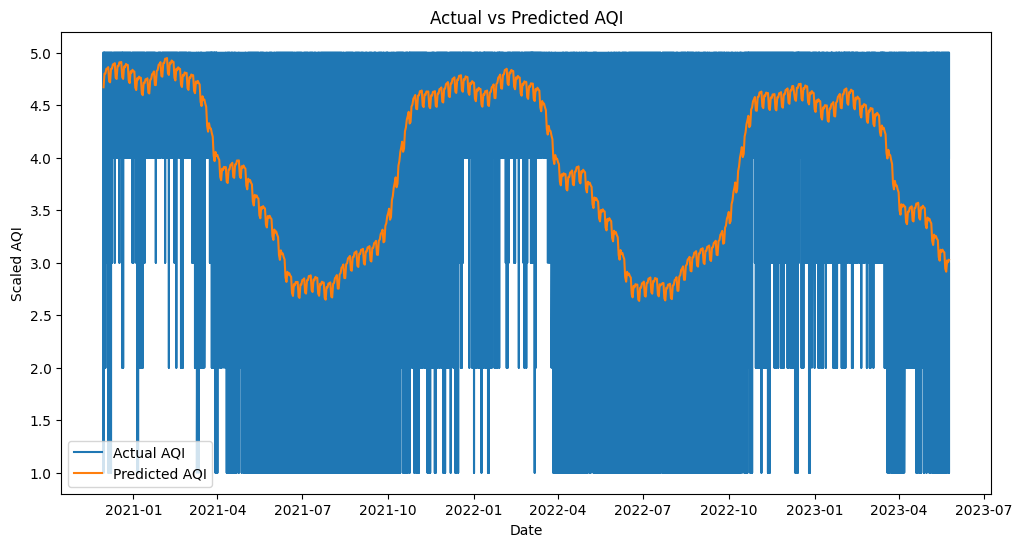

In [19]:
plt.figure(figsize=(12,6))
plt.plot(merged['ds'], y_true, label="Actual AQI")
plt.plot(merged['ds'], y_pred, label="Predicted AQI")
plt.title("Actual vs Predicted AQI")
plt.xlabel("Date")
plt.ylabel("Scaled AQI")
plt.legend()
plt.show()